## Parameter Estimation with SciPy's Differential Evolution Method in PyBOP

In this notebook, we demonstrate an example of parameter estimation for a single-particle model using the Differential Evolution optimiser. The Differential Evolution (DE) algorithm is a stochastic population-based method that is well-suited for multi-dimensional functions. Unlike gradient-based methods, which require gradient information and can easily become trapped in local minima, DE relies on the concept of evolving a population of candidate solutions, using operations like mutation, crossover, and selection. This approach allows DE to search large areas of the solution space, which makes it highly effective for dealing with complex, nonlinear, and multimodal objective functions. 

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [2]:
import numpy as np

import pybop

### Generate Synthetic Data

To demonstrate parameter estimation, we first need some data. We will generate synthetic data using the PyBOP forward model, which requires defining a parameter set and the model itself.

#### Defining Parameters and Model

We start by creating an example parameter set and then instantiate the single-particle model (SPM):

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
model = pybop.lithium_ion.SPM(parameter_set=parameter_set)

### Simulating Forward Model

We can then simulate the model using the `predict` method, with a default constant current to generate voltage data.

In [4]:
t_eval = np.arange(0, 900, 2)
values = model.predict(t_eval=t_eval)

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [5]:
sigma = 0.001
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

## Identify the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating Optimisation Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [6]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds:

In [7]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.6, 0.02),
        bounds=[0.5, 0.8],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.48, 0.02),
        bounds=[0.4, 0.7],
    ),
]

### Setting up the Optimisation Problem

With the datasets and parameters defined, we can set up the optimisation problem, its cost function, and the optimiser.

In [8]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)
optim = pybop.Optimisation(
    cost, optimiser=pybop.SciPyDifferentialEvolution, max_iterations=400
)

### Running the Optimisation

We proceed to run the Differential Evolution optimisation algorithm to estimate the parameters:

In [9]:
x, final_cost = optim.run()

Ignoring x0. Initial conditions are not used for differential_evolution.


### Viewing the Estimated Parameters

After the optimisation, we can examine the estimated parameter values:

In [10]:
x  # This will output the estimated parameters

array([0.75175283, 0.66487119])

## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation.

### Comparing System Response

We can quickly plot the system's response using the estimated parameters compared to the target:

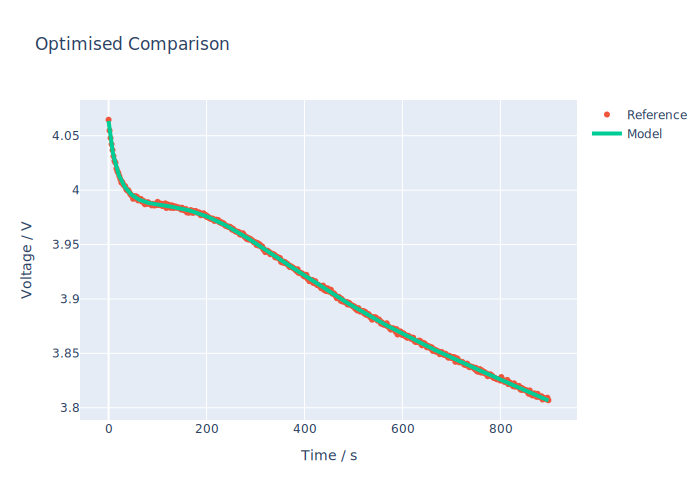

In [11]:
pybop.quick_plot(problem, parameter_values=x, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

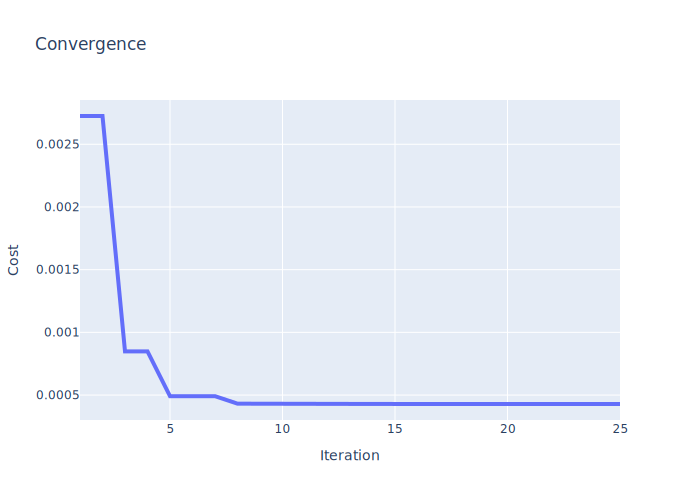

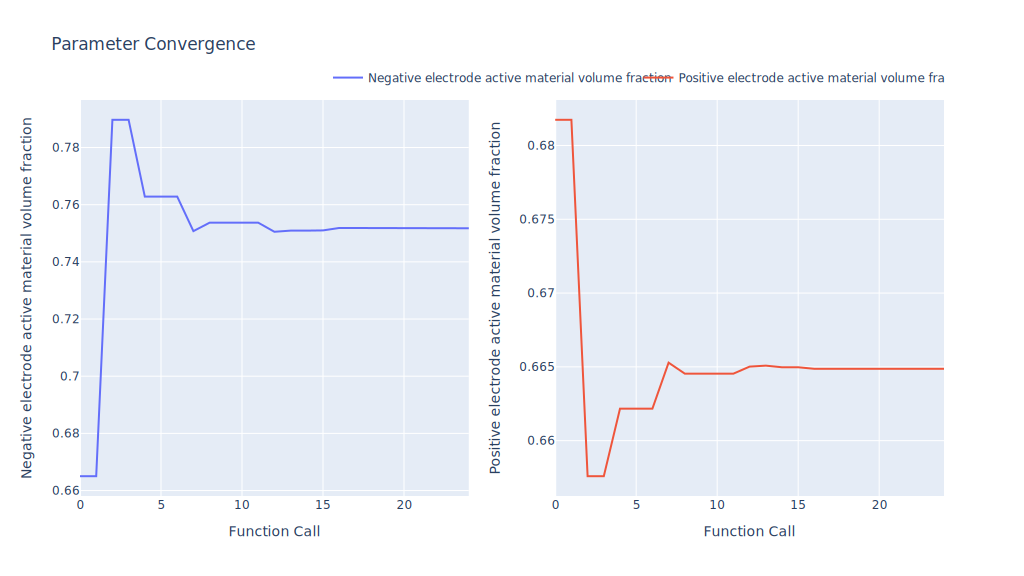

In [12]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser:

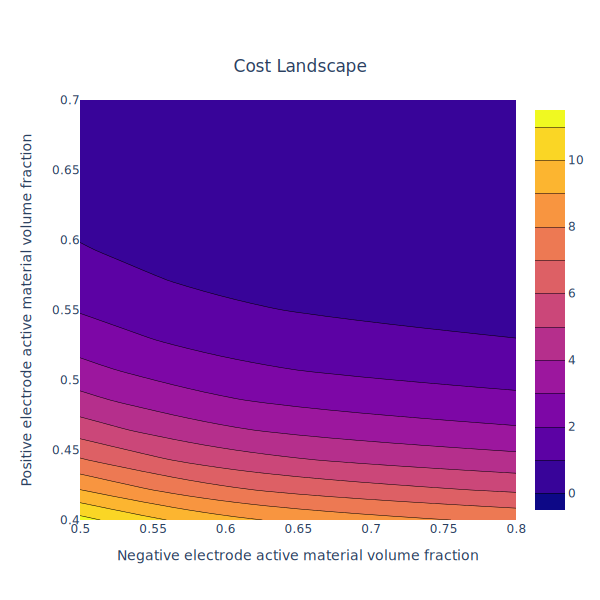

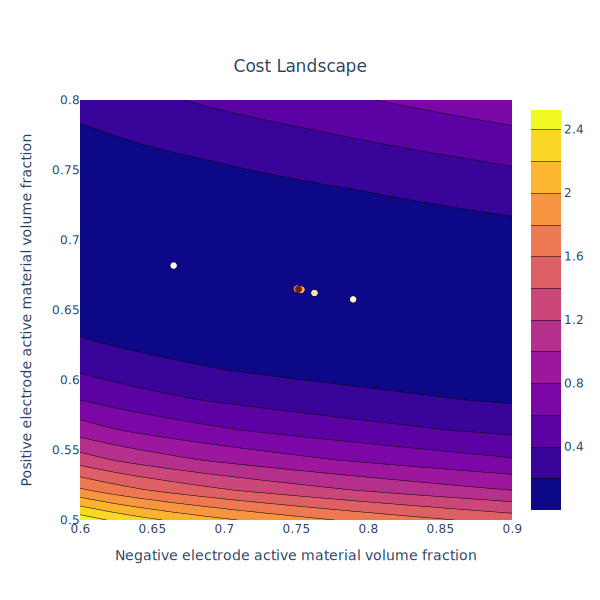

In [13]:
# Plot the cost landscape
pybop.plot2d(cost, steps=15)
# Plot the cost landscape with optimisation path and updated bounds
bounds = np.array([[0.6, 0.9], [0.5, 0.8]])
pybop.plot2d(optim, bounds=bounds, steps=15);

### Conclusion

This notebook illustrates how to perform parameter estimation using Differential Evolution method in PyBOP, providing insights into the optimisation process through various visualisations.